# setup

In [1]:
import h5py
import numpy as np
import os
import pandas as pd
import sys

from util.trial_analysis import get_trial_len
from util.trial_analysis import plot_cell_tuning_curve
from util.trial_analysis import plot_repeat_response

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 

from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# %matplotlib notebook
# %matplotlib qt

from __future__ import print_function

drive_path = '/data/dynamic-brain-workshop/visual_behavior'
manifest_file = 'visual_behavior_data_manifest.csv'
manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

In [2]:
# find experiment ids
targeted_structure = 'VISp'
cre_line = 'Slc17a7-IRES2-Cre'
# cre_line = 'Vip-IRES-Cre'
session_type = 'behavior_session_A'
manifest[(manifest['targeted_structure']==targeted_structure) & (manifest['cre_line']==cre_line) & (manifest['session_type']==session_type)]

,experiment_id,experiment_container_id,targeted_structure,imaging_depth,cre_line,reporter_line,full_genotype,session_type,donor_id,specimen_id,experiment_date
11,652844352,652784528,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,333706,597617440,12/8/2017 11:25
14,639253368,639001089,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,334310,599659785,9/28/2017 14:14
22,670396087,670266085,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,355471,644831080,3/6/2018 13:37
26,685744008,682951696,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,369316,657448350,4/17/2018 11:43
52,720001924,719860866,VISp,175,Slc17a7-IRES2-Cre,Camk2a-tTA;Ai93,Slc17a7-IRES2-Cre;Camk2a-tTA;Ai93,behavior_session_A,384942,687987489,7/13/2018 14:33


V1, VIP: experiment_id=695471168, cells are tuned to gray

In [3]:
experiment_id = 720001924
experiment_container_id = manifest[manifest.experiment_id==experiment_id].experiment_container_id.values[0]

dataset= VisualBehaviorOphysDataset(experiment_id, cache_dir=drive_path)
# dataset.metadata

# trial stimulus parameters

In [4]:
# import analysis object
analysis = ResponseAnalysis(dataset)

loading trial response dataframe
loading flash response dataframe


In [5]:
# get image names
stim_table = dataset.get_stimulus_table()
im_name = stim_table['image_name'].unique()
num_im = len(im_name)

# get timestamps
stim_ts = dataset.get_timestamps_stimulus()
ophys_ts = dataset.get_timestamps_ophys()

# dff traces
_, dff = dataset.get_dff_traces()
num_cell = dff.shape[0]

# get flash information
trial_len = get_trial_len(dataset)

# get average response matrix

In [6]:
# parameters
repeat_start = 1 # start from which repeat in the trial (start with 0)
len_cutoff = 10 # length of trials

In [7]:
# stimlus duration in frames
stim_duration_frame = int(np.ceil(analysis.stimulus_duration*analysis.ophys_frame_rate))
baseline_duration_frame = 3 # number of frames for baseline

# get response matrix for each flash in each trial
# repeat_resp = np.zeros([num_cell, num_im, len_cutoff, stim_duration_frame*2]) # full response matrix before averaging
avg_resp = [None]*num_im # np.zeros([num_cell, num_im, len_cutoff]) # num_neuron by num_im by len_cutoff

for im in range(num_im): # loop over image templates

    im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length'] >= len_cutoff + repeat_start))[0]
    avg_resp[im] = np.zeros([num_cell, len_cutoff, len(im_trials)])
    
    for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

        for repeat_ind, j in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial
            flash_start = stim_table['start_time'][j]
            stim_start = np.argmax(ophys_ts >= flash_start)
            stim_frames = np.arange(stim_start, stim_start+stim_duration_frame)
            baseline_frames = np.arange(stim_start-baseline_duration_frame, stim_start)

            for neuron in range(num_cell):
                avg_resp[im][neuron, repeat_ind, i] = dff[neuron, stim_frames].mean() - dff[neuron, baseline_frames].mean()

plot average response matrix

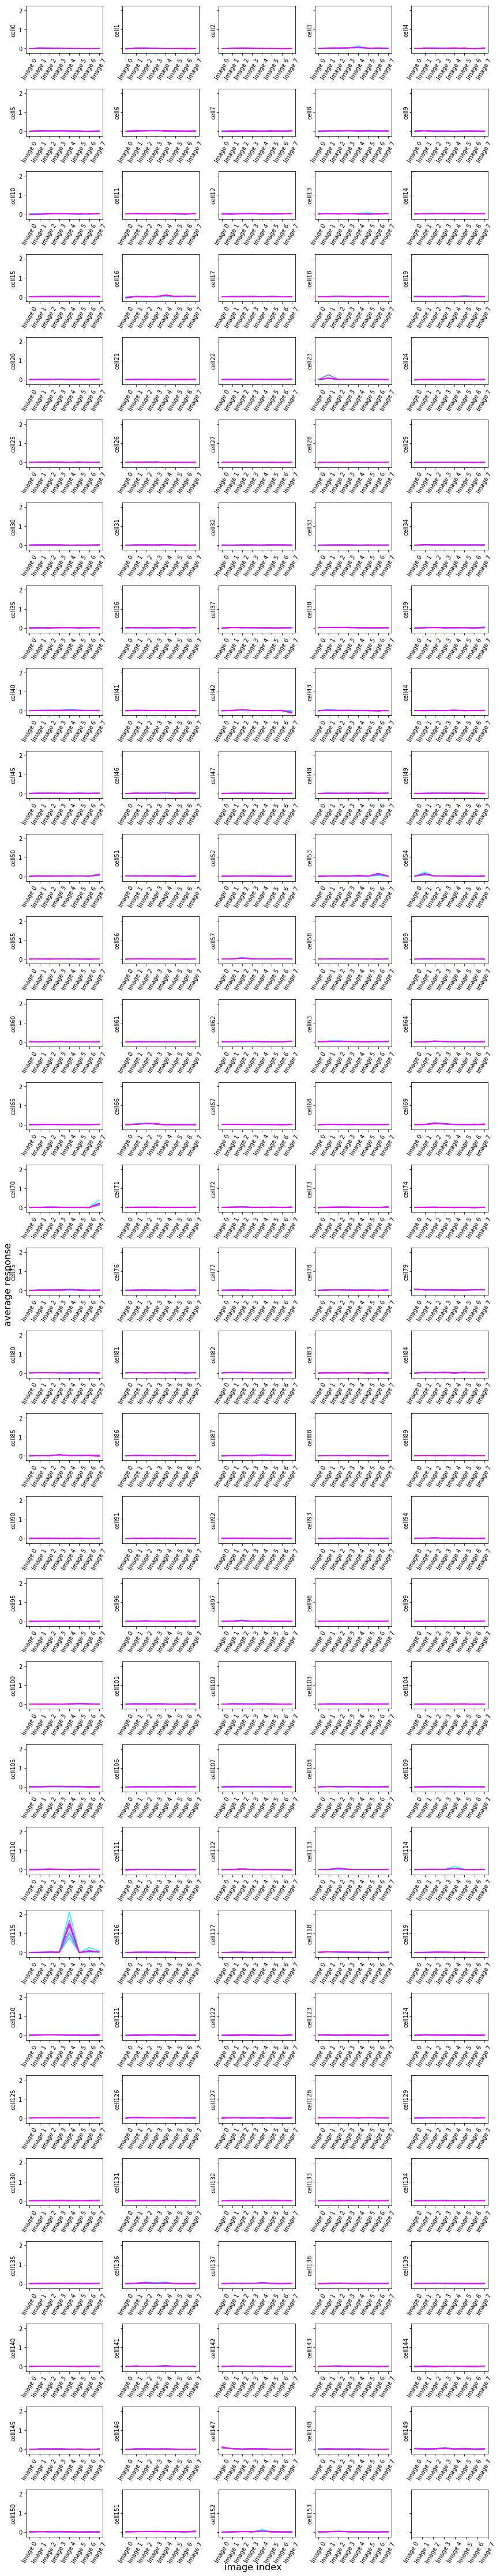

In [8]:
# plot_cell_tuning_curve(avg_resp)

# set colors
color_idx = np.linspace(0, 1, len_cutoff)

# loop over cells
num_cell_per_row = 5
cmap = cm.cool
num_row = int(np.ceil(float(num_cell)/float(num_cell_per_row)))

# collect result from all image templates
im_resp_avg = np.zeros([num_cell, num_im, len_cutoff])
im_resp_se = np.zeros([num_cell, num_im, len_cutoff])

# create plot
fig, axes = plt.subplots(num_row, num_cell_per_row, sharey=True, figsize=(12, num_row*2))
if num_row==1:
    axes = np.reshape(axes, (num_cell_per_row,-1))

for row in range(num_row):

    cell_start = row*num_cell_per_row
    cell_end = np.max([row*num_cell_per_row+1, num_cell])
    for cell, ax in zip(np.arange(cell_start, cell_end), axes[row,:]): # loop over cells
        
        for im in range(num_im):
            for r in range(len_cutoff):
                im_resp_avg[cell, im, r] = np.mean(avg_resp[im][cell, r, :])
                im_resp_se[cell, im, r] = np.std(avg_resp[im][cell, r, :])/np.sqrt(avg_resp[im].shape[2])
        
        for i, c in zip(range(len_cutoff),color_idx): # loop over repeats
            
#             ax.plot(avg_resp[cell,:,i], color=cmap(c))
            ax.plot(im_resp_avg[cell,:,i], color=cmap(c))
            ax.set_ylabel('cell' + str(cell))

fig.text(0.5, 0, 'image index', ha='center', fontsize=16)
fig.text(0, 0.5, 'average response', va='center', fontsize=16, rotation='vertical')
plt.setp(axes, xticks=range(8), xticklabels=['Image 0', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7'])
for ax in axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation=60)
plt.tight_layout()
plt.show()

fig.savefig('fig/tuning_curve_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '.pdf')

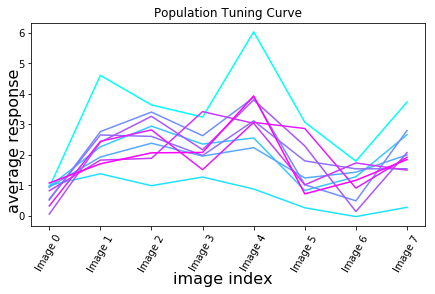

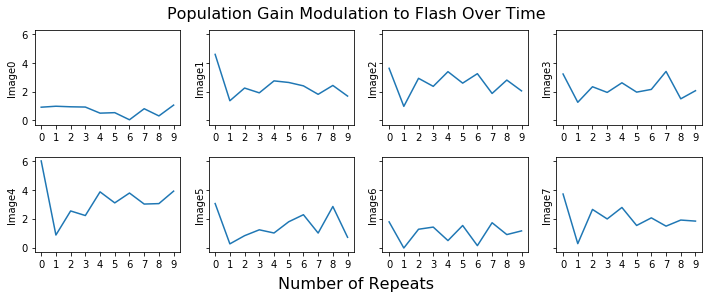

In [30]:
# population tuning curve

# create plot
fig, ax = plt.subplots(figsize=(6,4))
for r, c in zip(range(len_cutoff),color_idx):
    ax.plot(np.sum(im_resp_avg[:,:,r], axis=0), color=cmap(c))

fig.text(0.5, 0, 'image index', ha='center', fontsize=16)
fig.text(0, 0.5, 'average response', va='center', fontsize=16, rotation='vertical')
plt.setp(ax, xticks=range(8), xticklabels=['Image 0', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7'])
plt.setp(ax.get_xticklabels(), rotation=60)
plt.title('Population Tuning Curve - Flash')
plt.tight_layout()
plt.show()
fig.savefig('fig/population_tuning_curve_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '.pdf')

######################################################################
# gain modulation for each image over time
fig, axes = plt.subplots(2, 4, sharey=True, figsize=[10,4])

for im, ax in zip(range(num_im), axes.ravel()):
    ax.plot(np.sum(im_resp_avg[:,im,:], axis=0))
#     ax.errorbar(np.arange(len_cutoff), np.sum(im_resp_avg[:,im,:], axis=0), yerr=im_resp_se[cell,im,:], capsize=3)
    ax.set_xticks(np.arange(len_cutoff))
    ax.set_ylabel('Image' + str(im))
    
fig.text(0.5, 0, 'Number of Repeats', ha='center', fontsize=16)
# fig.text(0, 0.5, 'Population Gain', va='center', fontsize=16, rotation='vertical')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Population Gain Modulation to Flash Over Time', fontsize=16)

plt.show()
fig.savefig('fig/population_tuning_curve_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_gain.pdf')

In [ ]:
cell = 115 # cell index, start from 0
im = 4 # which image to plot
# repeat = 1 # which repeat to plot, start from 0

# get trial data
im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length']>len_cutoff))[0]
trial_rsp_mat = np.zeros([len(im_trials), len_cutoff, int(stim_duration_frame)*2])

for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

    for j, repeat_ind in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial

        # define frames for current trial block, current repeat
        flash_start = stim_table['start_time'][repeat_ind]
        stim_start = np.argmax(ophys_ts >= flash_start)
        frames = np.arange(stim_start-stim_duration_frame, stim_start+stim_duration_frame)

        # store result
        trial_rsp_mat[i, j, :] = dff[cell, frames]
        
######################################################################
# plot repeate response for selected cell and repeat number

# timestamps for repeats
repeat_ts = np.arange(0, stim_duration_frame*2) / analysis.ophys_frame_rate

fig, axes = plt.subplots(2, 5, sharey=True, figsize=[12,3]) # assume len_cutoff = 10 for now

for repeat ,ax in zip(range(len_cutoff), axes.reshape(-1)):
    
    # plot individual repeats
    for i in range(trial_rsp_mat.shape[0]):
        ax.plot(repeat_ts, trial_rsp_mat[i, repeat, :], color=(0.7, 0.7, 0.7))
    
    # plot average response
    ax.plot(repeat_ts, trial_rsp_mat[:, repeat, :].mean(axis=0), color='r', linewidth=1.5)

    # plot stim time
    ax.axvline(x=repeat_ts[int(stim_duration_frame)], color='k', linewidth=1, linestyle='--')
    ax.set_xlim([repeat_ts[0], repeat_ts[-1]])
    ax.set_ylabel('Repeat ' + str(repeat))

plt.tight_layout()
plt.suptitle('Response to Flash Over Time - cell ' + str(cell) + ', image ' + str(im) + ', stim', fontsize=16)
fig.text(0.5, 0, 'time (s)', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig('fig/cell_response/cell_response_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_cell_' + str(cell) + '_image_' + str(im) + '.pdf')

########################################################################
# plot gain over repeats
fig, ax = plt.subplots(figsize=[6,3])

ax.errorbar(np.arange(len_cutoff), im_resp_avg[cell,im,:], yerr=im_resp_se[cell,im,:], capsize=3)
ax.set_xticks(np.arange(len_cutoff))
# ax.set_ylim(bottom=0)
ax.set_xlabel('Number of repeats')
ax.set_ylabel('Gain')
ax.set_title('Gain Modulation to Flash Over Time - cell ' + str(cell) + ', image ' + str(im), fontsize=16)

plt.show()

fig.savefig('fig/cell_response/cell_response_flash_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_cell_' + str(cell) + '_image_' + str(im) + '_gain.pdf')

# inter-stimulus gray period response

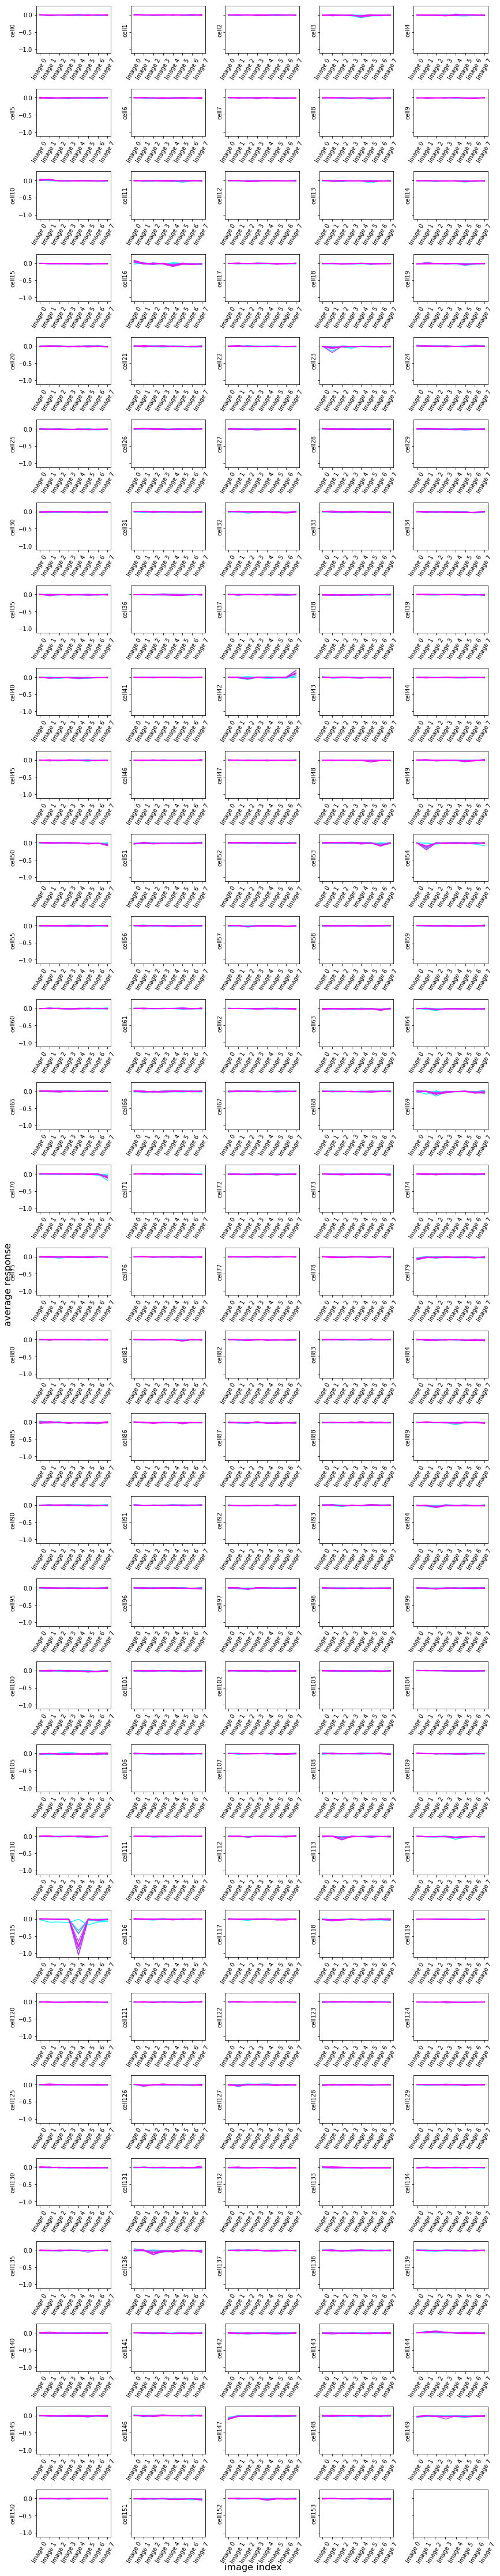

In [32]:
# stimlus duration in frames
gray_duration_frame = int(np.ceil(analysis.stimulus_duration*analysis.ophys_frame_rate)*2)
gray_baseline_frame = 3

# get response matrix for each flash in each trial
avg_resp_gray = [None]*num_im

for im in range(num_im): # loop over image templates

    im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length']>len_cutoff+repeat_start))[0]
    avg_resp_gray[im] = np.zeros([num_cell, len_cutoff, len(im_trials)])
    
    for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

        for repeat_ind, j in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial
            flash_start = stim_table['start_time'][j]
            gray_end = np.argmax(ophys_ts >= flash_start)
            gray_start = gray_end-gray_duration_frame
            gray_frames_baseline = np.arange(gray_start, gray_start+gray_baseline_frame)
            gray_frames_later = np.arange(gray_start+gray_baseline_frame, gray_end)

            for neuron in range(num_cell):
                avg_resp_gray[im][neuron, repeat_ind, i] = dff[neuron, gray_frames_later].mean() - dff[neuron, gray_frames_baseline].mean()


#################################################################
# plot tuning curve
# plot_cell_tuning_curve(avg_resp_gray)

# set colors
color_idx = np.linspace(0, 1, len_cutoff)

# loop over cells
num_cell_per_row = 5
cmap = cm.cool
num_row = int(np.ceil(float(num_cell)/float(num_cell_per_row)))

# collect result from all image templates
gray_resp_avg = np.zeros([num_cell, num_im, len_cutoff])
gray_resp_se = np.zeros([num_cell, num_im, len_cutoff])

# create plot
fig, axes = plt.subplots(num_row, num_cell_per_row, sharey=True, figsize=(12,num_row*2))

for row in range(num_row):

    cell_start = row*num_cell_per_row
    cell_end = np.max([row*num_cell_per_row+1, num_cell])
    for cell, ax in zip(np.arange(cell_start, cell_end), axes[row,:]): # loop over cells

        for im in range(num_im):
            for r in range(len_cutoff):
                gray_resp_avg[cell, im, r] = np.mean(avg_resp_gray[im][cell, r, :])
                gray_resp_se[cell, im, r] = np.std(avg_resp_gray[im][cell, r, :])/np.sqrt(avg_resp[im].shape[2])
        
        for i, c in zip(range(len_cutoff),color_idx): # loop over repeats
            ax.plot(gray_resp_avg[cell,:,i], color=cmap(c))
            ax.set_ylabel('cell' + str(cell))
            
        #ax.set_xticks(range(8), ['Gray 0', 'Gray 1', 'Gray 2', 'Gray 3', 'Gray 4', 'Gray 5', 'Gray 6', 'Gray 7'])#, rotation=40)

fig.text(0.5, 0, 'image index', ha='center', fontsize=16)
fig.text(0, 0.5, 'average response', va='center', fontsize=16, rotation='vertical')
plt.setp(axes, xticks=range(8), xticklabels=['Image 0', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7'])
for ax in axes.ravel():
    plt.setp(ax.get_xticklabels(), rotation=60)
plt.tight_layout()
plt.show()

fig.savefig('fig/tuning_curve_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '.pdf')

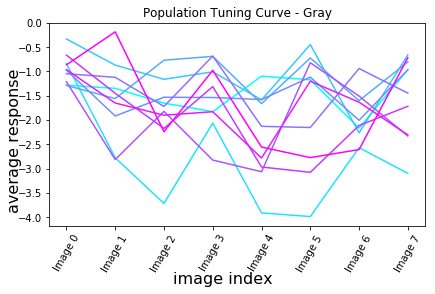

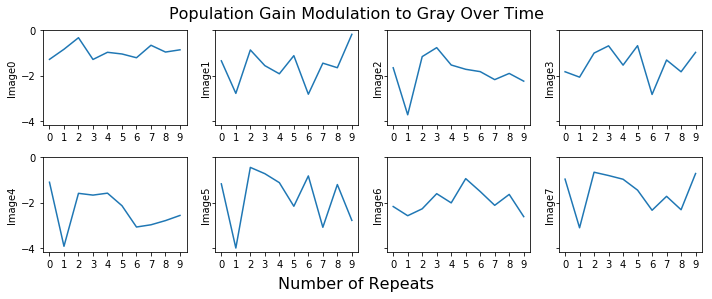

In [33]:
# population tuning curve

# create plot
fig, ax = plt.subplots(figsize=(6,4))
for r, c in zip(range(len_cutoff),color_idx):
    ax.plot(np.sum(gray_resp_avg[:,:,r], axis=0), color=cmap(c))

fig.text(0.5, 0, 'image index', ha='center', fontsize=16)
fig.text(0, 0.5, 'average response', va='center', fontsize=16, rotation='vertical')
plt.setp(ax, xticks=range(8), xticklabels=['Image 0', 'Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 5', 'Image 6', 'Image 7'])
plt.setp(ax.get_xticklabels(), rotation=60)
plt.title('Population Tuning Curve - Gray')
plt.tight_layout()
plt.show()
fig.savefig('fig/population_tuning_curve_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '.pdf')

######################################################################
# gain modulation for each image over time
fig, axes = plt.subplots(2, 4, sharey=True, figsize=[10,4])

for im, ax in zip(range(num_im), axes.ravel()):
    ax.plot(np.sum(gray_resp_avg[:,im,:], axis=0))
#     ax.errorbar(np.arange(len_cutoff), np.sum(im_resp_avg[:,im,:], axis=0), yerr=im_resp_se[cell,im,:], capsize=3)
    ax.set_xticks(np.arange(len_cutoff))
    ax.set_ylabel('Image' + str(im))
    
fig.text(0.5, 0, 'Number of Repeats', ha='center', fontsize=16)
# fig.text(0, 0.5, 'Population Gain', va='center', fontsize=16, rotation='vertical')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Population Gain Modulation to Gray Over Time', fontsize=16)

plt.show()
fig.savefig('fig/population_tuning_curve_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_gain.pdf')

########################################################################
# plot gain over repeats
fig, ax = plt.subplots(figsize=[6,3])

ax.errorbar(np.arange(len_cutoff), gray_resp_avg[cell,im,:], yerr=gray_resp_se[cell,im,:], capsize=3)
ax.set_xticks(np.arange(len_cutoff))
# ax.set_ylim(bottom=0)
ax.set_xlabel('Number of repeats')
ax.set_ylabel('Gain')
ax.set_title('Gain Modulation to Gray Over Time - cell ' + str(cell) + ', image ' + str(im), fontsize=16)

plt.show()

fig.savefig('fig/cell_response/cell_response_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_cell_' + str(cell) + '_image_' + str(im) + '_gain.pdf')

In [ ]:
cell = 127 # cell index, start from 0
im = 2 # which image to plot

# get trial data
im_trials = np.where((trial_len['image']==im_name[im]) & (trial_len['trial_length']>len_cutoff+repeat_start))[0]
gray_rsp_mat = np.zeros([len(im_trials), len_cutoff, int(stim_duration_frame)*2])

for i, trial_block_id in enumerate(im_trials): # loop over trials for the image template

    for j, repeat_ind in enumerate(np.arange(trial_len['trial_start'][trial_block_id]+repeat_start, trial_len['trial_start'][trial_block_id]+len_cutoff+repeat_start, 1)): # loop over flashes in each trial

        # define frames for current trial block, current repeat
        flash_start = stim_table['start_time'][repeat_ind]
        stim_start = np.argmax(ophys_ts >= flash_start)
        gray_frames = np.arange(stim_start-2*stim_duration_frame, stim_start)

        # store result
        gray_rsp_mat[i, j, :] = dff[cell, gray_frames]
        
######################################################################
# plot repeate response for selected cell and repeat number

# timestamps for repeats
gray_ts = np.arange(0, stim_duration_frame*2) / analysis.ophys_frame_rate

fig, axes = plt.subplots(2, 5, sharey=True, figsize=[12,3]) # assume len_cutoff = 10 for now

for repeat ,ax in zip(range(len_cutoff), axes.reshape(-1)):
    
    # plot individual repeats
    for i in range(gray_rsp_mat.shape[0]):
        ax.plot(gray_ts, gray_rsp_mat[i, repeat, :], color=(0.7, 0.7, 0.7))
    
    # plot average response
    ax.plot(gray_ts, gray_rsp_mat[:, repeat, :].mean(axis=0), color='r', linewidth=1.5)

    # plot stim time
    # ax.axvline(x=repeat_ts[int(stim_duration_frame)], color='k', linewidth=1, linestyle='--')
    ax.set_xlim([gray_ts[0], gray_ts[-1]])
    ax.set_ylabel('Repeat ' + str(repeat))

plt.tight_layout()
plt.suptitle('Response to Gray Over Time - cell ' + str(cell) + ', image ' + str(im) + ', gray', fontsize=16)
fig.text(0.5, 0, 'time (s)', ha='center', fontsize=16)
# fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
plt.subplots_adjust(top=0.9)
plt.show()

fig.savefig('fig/cell_response/cell_response_gray_' + targeted_structure + '_' + cre_line + '_' + str(experiment_id) + '_cell_' + str(cell) + '_gray_' + str(im) + '.pdf')